In [1]:
%config Completer.use_jedi = False

In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

import xgboost as xgb

from joblib import dump, load
import pyodbc

In [3]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-JC08B71;'
                      'Database=LendingClub;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()

In [4]:
df = pd.read_sql_query('SELECT * FROM LendingClub.dbo.LendingClubView', conn)

In [5]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec,revol_bal,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zip_code,state,loan_status
0,10000.0,36,11.44,329.48,B,B4,10+ years,RENT,117000.0,Not Verified,...,0.0,36369.0,25.0,w,INDIVIDUAL,0.0,0.0,22690,OK,Fully Paid
1,8000.0,36,11.99,265.68,B,B5,4 years,MORTGAGE,65000.0,Not Verified,...,0.0,20131.0,27.0,f,INDIVIDUAL,3.0,0.0,05113,SD,Fully Paid
2,15600.0,36,10.49,506.97,B,B3,< 1 year,RENT,43057.0,Source Verified,...,0.0,11987.0,26.0,f,INDIVIDUAL,0.0,0.0,05113,WV,Fully Paid
3,7200.0,36,6.49,220.65,A,A2,6 years,RENT,54000.0,Not Verified,...,0.0,5472.0,13.0,f,INDIVIDUAL,0.0,0.0,00813,MA,Fully Paid
4,24375.0,60,17.27,609.33,C,C5,9 years,MORTGAGE,55000.0,Verified,...,0.0,24584.0,43.0,f,INDIVIDUAL,1.0,0.0,11650,VA,Charged Off


In [6]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec,revol_bal,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zip_code,state,loan_status
0,10000.0,36,11.44,329.48,B,B4,10+ years,RENT,117000.0,Not Verified,...,0.0,36369.0,25.0,w,INDIVIDUAL,0.0,0.0,22690,OK,Fully Paid
1,8000.0,36,11.99,265.68,B,B5,4 years,MORTGAGE,65000.0,Not Verified,...,0.0,20131.0,27.0,f,INDIVIDUAL,3.0,0.0,05113,SD,Fully Paid
2,15600.0,36,10.49,506.97,B,B3,< 1 year,RENT,43057.0,Source Verified,...,0.0,11987.0,26.0,f,INDIVIDUAL,0.0,0.0,05113,WV,Fully Paid
3,7200.0,36,6.49,220.65,A,A2,6 years,RENT,54000.0,Not Verified,...,0.0,5472.0,13.0,f,INDIVIDUAL,0.0,0.0,00813,MA,Fully Paid
4,24375.0,60,17.27,609.33,C,C5,9 years,MORTGAGE,55000.0,Verified,...,0.0,24584.0,43.0,f,INDIVIDUAL,1.0,0.0,11650,VA,Charged Off


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395852 entries, 0 to 395851
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   loan_amnt               395852 non-null  float64
 1   term                    395852 non-null  object 
 2   int_rate                395852 non-null  float64
 3   installment             395852 non-null  float64
 4   grade                   395852 non-null  object 
 5   sub_grade               395852 non-null  object 
 6   emp_length              395852 non-null  object 
 7   home_ownership          395852 non-null  object 
 8   annual_inc              395852 non-null  float64
 9   verification_status     395852 non-null  object 
 10  issue_month             395852 non-null  int64  
 11  issue_year              395852 non-null  int64  
 12  purpose                 395852 non-null  object 
 13  dti                     395852 non-null  float64
 14  earliest_cr_line_mon

In [8]:
feature_info = pd.read_csv('../DATA/lending_club_info.csv', index_col='LoanStatNew')

In [9]:
feature_info

,Description
LoanStatNew,
loan_amnt,The listed amount of the loan applied for by t...
term,The number of months of payments on the loan. ...
int_rate,Interest Rate on the loan
installment,The monthly payment owed by the borrower if th...
grade,LC assigned loan grade
sub_grade,LC assigned loan subgrade
emp_title,The job title supplied by the Borrower when ap...
emp_length,Employment length in years. Possible values ar...
home_ownership,The home ownership status provided by the borr...


In [10]:
def get_feature_info(feature):
    return feature_info.loc[feature]['Description']

In [11]:
get_feature_info('state')

'The state provided by the borrower in the loan application'

In [13]:
# Make X and y
X = df.drop('loan_status', axis=1)
y = df['loan_status'] # target

# Create train, valid, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train = pd.concat([X_train, y_train], axis=1) # for ease of use when exploring data

# Investigating Nulls

I will now investigate the null values that remain after preprocessing in SQL.

In [14]:
(100*train.isnull().sum() / train.shape[0]).sort_values(ascending=False)

mort_acc                  9.570825
pub_rec_bankruptcies      0.137187
loan_amnt                 0.000000
earliest_cr_line_month    0.000000
state                     0.000000
zip_code                  0.000000
application_type          0.000000
initial_list_status       0.000000
total_acc                 0.000000
revol_bal                 0.000000
pub_rec                   0.000000
open_acc                  0.000000
earliest_cr_line_year     0.000000
dti                       0.000000
term                      0.000000
purpose                   0.000000
issue_year                0.000000
issue_month               0.000000
verification_status       0.000000
annual_inc                0.000000
home_ownership            0.000000
emp_length                0.000000
sub_grade                 0.000000
grade                     0.000000
installment               0.000000
int_rate                  0.000000
loan_status               0.000000
dtype: float64

There are only two features which include nulls: mort_acc and pub_rec_bankruptcies.

I will look into those now.

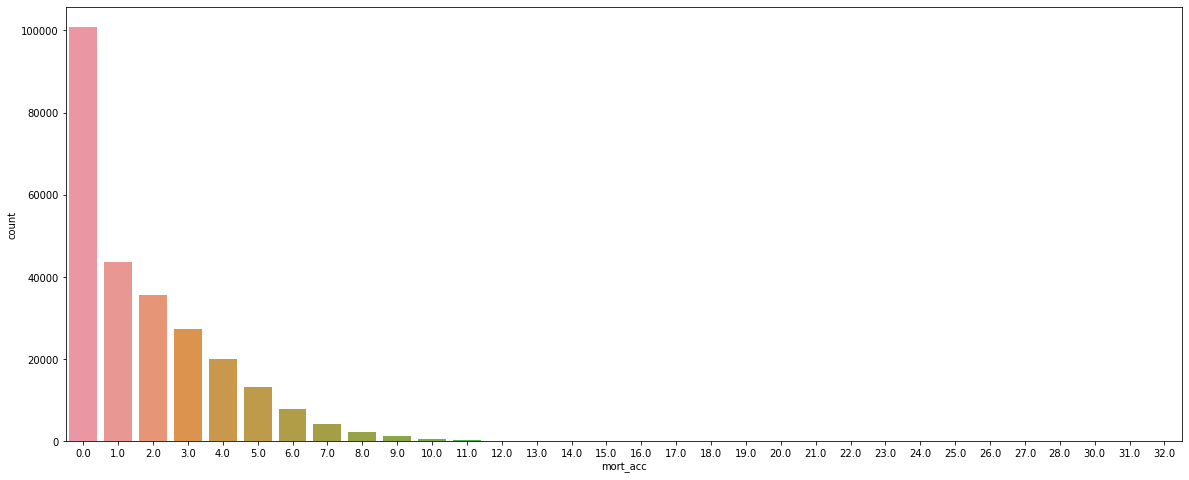

In [15]:
plt.figure(figsize=(20, 8))
sns.countplot(data=train, x='mort_acc')
plt.show()

As we can see, the vast majority of the mort_acc data is <= 9.0.
I will see if there is an obvious difference in Fully Paid vs. Charged Off for this portion of the data

In [16]:
def visualize_proportions(feature, ordering=None, figsize=(12,8)):
    counts_per_feat = train.groupby(feature).size().reset_index().rename({0: 'total'}, axis=1)
    counts_per_feat_loan_status = train.groupby([feature, 'loan_status']).size().reset_index().rename({0:'split'}, axis=1)

    # merge the two on mort_acc

    merged_counts = pd.merge(counts_per_feat, 
                             counts_per_feat_loan_status, 
                             on=feature)       


    merged_counts['proportion'] = merged_counts['split']/merged_counts['total']

    charged_off_props = merged_counts[merged_counts['loan_status']=='Charged Off']

    plt.figure(figsize=figsize)
    sns.barplot(data=charged_off_props, x=feature, y='proportion', order=ordering)
    plt.title(f'Proportion of Charged Off vs. {feature}')
    plt.ylabel('Proportion of Charged Off')
    plt.show()

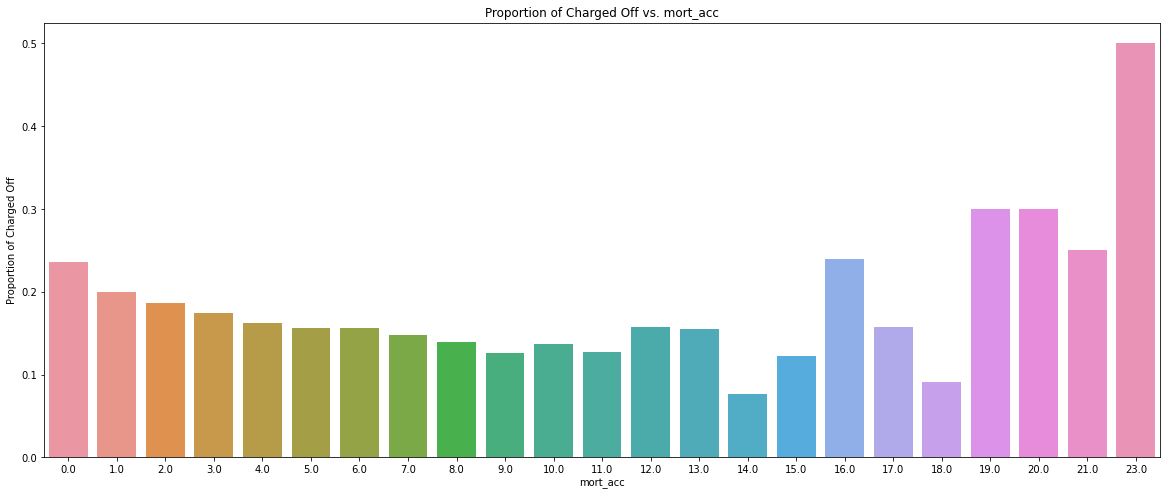

In [17]:
visualize_proportions('mort_acc', figsize=(20, 8))

As we can see, as the number of mort_acc increases, the proportion of charged off decreases, indicating that this feature may be useful and we should try to keep it.

Since ~9.5% of the data is missing, it would be best to try to fill it in as deleting this much data would not be the best decision.

I will first look into it's most correlated feature.

In [18]:
train.corr()['mort_acc'].sort_values(ascending=False)[1:]

total_acc                 0.381435
annual_inc                0.232181
loan_amnt                 0.221785
installment               0.193179
revol_bal                 0.192607
open_acc                  0.107682
pub_rec_bankruptcies      0.028925
issue_year                0.012472
pub_rec                   0.012205
issue_month              -0.007043
earliest_cr_line_month   -0.020557
dti                      -0.022582
int_rate                 -0.083311
earliest_cr_line_year    -0.291134
Name: mort_acc, dtype: float64

As we can see, total_acc is most highly correlated to mort_acc.

In [19]:
get_feature_info('mort_acc')

'Number of mortgage accounts.'

In [20]:
get_feature_info('total_acc')

"The total number of credit lines currently in the borrower's credit file"

By the definitions, it is not a surprise that mort_acc is closely related to total_acc

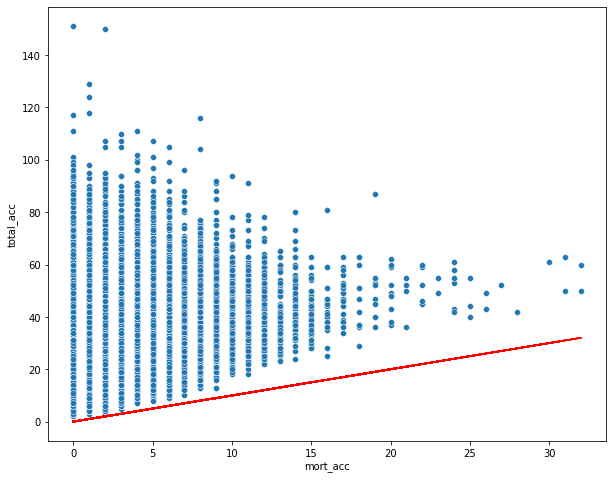

In [21]:
plt.figure(figsize=(10, 8))

sns.scatterplot(data=train, x='mort_acc', y='total_acc')
plt.plot(train['mort_acc'], train['mort_acc'], color='r')
plt.show()

The red line depicts mort_acc against itself, and by definition, we should see total_acc >= mort_acc, which we do.

From this picture, using a linear model to fit the number of missing mort_acc based on the number of total_acc seems naive.
It may be best to investigate total_acc further.

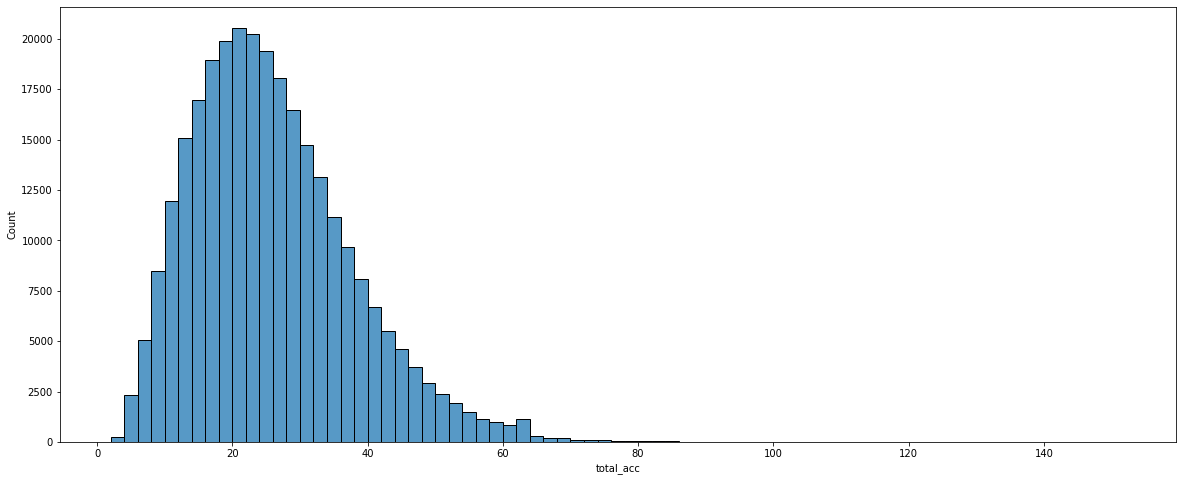

In [22]:
plt.figure(figsize=(20, 8))

sns.histplot(data=train, x='total_acc', binwidth=2)
plt.show()

There is quite a range of total_acc, but most occur between 5-50. With a good amount, grouping by the total_acc and imputing the mean mort_acc amount into the nulls is a good idea.

In [23]:
total_mort_means = train.groupby('total_acc').mean()['mort_acc']

total_mort_means[2.0] # the number to put in if mort_acc is null and total_acc = 2.0

0.0

In [24]:
def fill_mort_acc(total_acc, mort_acc):
    """
    Fill in the missing 'mort_acc' values
    with the mean of the 'total_acc' values
    grouped together by the total_acc number.
    """
    if np.isnan(mort_acc):
        if total_acc in total_mort_means.index:
            return total_mort_means[total_acc]
        else:
            return mort_acc
    else:
        return mort_acc

In [25]:
train['mort_acc'] = train.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [26]:
train.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_length                  0
home_ownership              0
annual_inc                  0
verification_status         0
issue_month                 0
issue_year                  0
purpose                     0
dti                         0
earliest_cr_line_month      0
earliest_cr_line_year       0
open_acc                    0
pub_rec                     0
revol_bal                   0
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                    0
pub_rec_bankruptcies      391
zip_code                    0
state                       0
loan_status                 0
dtype: int64

I will now look into the pub_rec_bankruptcies.

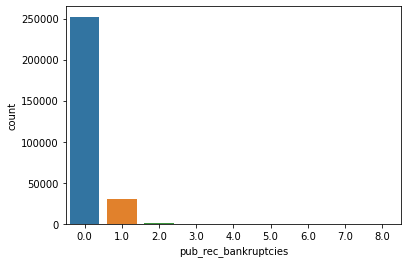

In [27]:
sns.countplot(data=train, x='pub_rec_bankruptcies')
plt.show()

As we can see, almost all pub_rec_bankruptcies are 0, putting in a default value of 0 could be useful. However, like above, we can see if any features are highly correlated to make a better imputation.

In [28]:
train.corr()['pub_rec_bankruptcies'].sort_values(ascending=False)[1:]

pub_rec                   0.695388
issue_year                0.109887
int_rate                  0.058535
total_acc                 0.041958
mort_acc                  0.030989
earliest_cr_line_month   -0.005598
dti                      -0.012373
issue_month              -0.017345
open_acc                 -0.028500
annual_inc               -0.049183
earliest_cr_line_year    -0.057532
installment              -0.099481
loan_amnt                -0.107289
revol_bal                -0.124317
Name: pub_rec_bankruptcies, dtype: float64

We can see that pub_rec is pretty highly correlated.

In [29]:
get_feature_info('pub_rec_bankruptcies')

'Number of public record bankruptcies'

In [30]:
get_feature_info('pub_rec')

'Number of derogatory public records'

And looking at the definition, it makes sense as a bankruptcy is a type of derogatory public record

(0.0, 20.0)

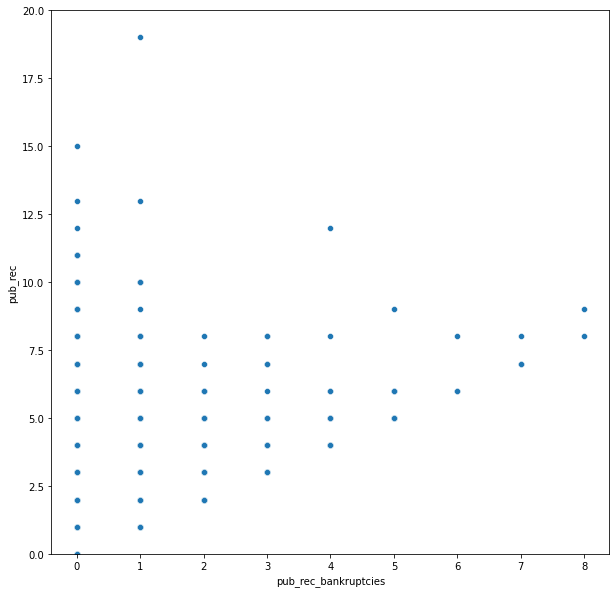

In [31]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=train, x='pub_rec_bankruptcies', y='pub_rec')
plt.ylim(0, 20)

Due to the discrete nature of these features, it is hard to tell much since we only have points. Like with the mort_acc, it may make sense to perform a grouping and take the mean to be the imputer.

In [32]:
train.groupby('pub_rec').mean()['pub_rec_bankruptcies']

pub_rec
0.0     0.000000
1.0     0.811615
2.0     0.925945
3.0     1.057624
4.0     1.155673
5.0     1.117647
6.0     0.858824
7.0     0.711111
8.0     1.480000
9.0     1.400000
10.0    0.333333
11.0    0.000000
12.0    2.000000
13.0    0.500000
15.0    0.000000
19.0    1.000000
24.0    0.000000
86.0    1.000000
Name: pub_rec_bankruptcies, dtype: float64

In [33]:
train['pub_rec'].mean()

0.17799250557871246

In comparing the overall mean to the means from groupby, it makes more sense to use the grouping instead of the overall mean.

In [34]:
pub_rec_means = train.groupby('pub_rec').mean()['pub_rec_bankruptcies']

def fill_pub_rec_bank(pub_rec, pub_rec_bank):
    """
    Fill missing pub_rec_bankruptcies values with the mean
    of them grouped by the number of pub_rec.
    """
    if np.isnan(pub_rec_bank):
        if pub_rec in pub_rec_means.index:
            return pub_rec_means[pub_rec]
        else:
            return pub_rec_bank
    else:
        return pub_rec_bank

In [35]:
train['pub_rec_bankruptcies'] = train.apply(lambda x: fill_pub_rec_bank(x['pub_rec'], x['pub_rec_bankruptcies']), axis=1)

In [36]:
train.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
issue_month               0
issue_year                0
purpose                   0
dti                       0
earliest_cr_line_month    0
earliest_cr_line_year     0
open_acc                  0
pub_rec                   0
revol_bal                 0
total_acc                 0
initial_list_status       0
application_type          0
mort_acc                  0
pub_rec_bankruptcies      0
zip_code                  0
state                     0
loan_status               0
dtype: int64

Now that the nulls have been taken care of, I would like to impute nulls in the valid/train sets as well.

In [37]:
X_valid.isnull().sum()

loan_amnt                    0
term                         0
int_rate                     0
installment                  0
grade                        0
sub_grade                    0
emp_length                   0
home_ownership               0
annual_inc                   0
verification_status          0
issue_month                  0
issue_year                   0
purpose                      0
dti                          0
earliest_cr_line_month       0
earliest_cr_line_year        0
open_acc                     0
pub_rec                      0
revol_bal                    0
total_acc                    0
initial_list_status          0
application_type             0
mort_acc                  6712
pub_rec_bankruptcies        92
zip_code                     0
state                        0
dtype: int64

In [38]:
X_test.isnull().sum()

loan_amnt                    0
term                         0
int_rate                     0
installment                  0
grade                        0
sub_grade                    0
emp_length                   0
home_ownership               0
annual_inc                   0
verification_status          0
issue_month                  0
issue_year                   0
purpose                      0
dti                          0
earliest_cr_line_month       0
earliest_cr_line_year        0
open_acc                     0
pub_rec                      0
revol_bal                    0
total_acc                    0
initial_list_status          0
application_type             0
mort_acc                  3756
pub_rec_bankruptcies        52
zip_code                     0
state                        0
dtype: int64

In [39]:
X_valid['mort_acc'] = X_valid.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)
X_valid['pub_rec_bankruptcies'] = X_valid.apply(lambda x: fill_pub_rec_bank(x['pub_rec'], x['pub_rec_bankruptcies']), axis=1)

X_test['mort_acc'] = X_test.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)
X_test['pub_rec_bankruptcies'] = X_test.apply(lambda x: fill_pub_rec_bank(x['pub_rec'], x['pub_rec_bankruptcies']), axis=1)


<ipython-input-39-356ae80a0ed0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['mort_acc'] = X_test.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)
<ipython-input-39-356ae80a0ed0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pub_rec_bankruptcies'] = X_test.apply(lambda x: fill_pub_rec_bank(x['pub_rec'], x['pub_rec_bankruptcies']), axis=1)


In [40]:
X_valid.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
issue_month               0
issue_year                0
purpose                   0
dti                       0
earliest_cr_line_month    0
earliest_cr_line_year     0
open_acc                  0
pub_rec                   0
revol_bal                 0
total_acc                 0
initial_list_status       0
application_type          0
mort_acc                  0
pub_rec_bankruptcies      0
zip_code                  0
state                     0
dtype: int64

In [41]:
X_test.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
issue_month               0
issue_year                0
purpose                   0
dti                       0
earliest_cr_line_month    0
earliest_cr_line_year     0
open_acc                  0
pub_rec                   0
revol_bal                 0
total_acc                 0
initial_list_status       0
application_type          0
mort_acc                  0
pub_rec_bankruptcies      0
zip_code                  0
state                     0
dtype: int64

# Further EDA

Now that nulls have been taken care of, I want to look further into features on the training set.

In [42]:
train.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec,revol_bal,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zip_code,state,loan_status
112765,16200.0,36,14.33,556.28,C,C1,3 years,MORTGAGE,55000.0,Verified,...,0.0,12963.0,17.0,f,INDIVIDUAL,1.0,0.0,00813,AA,Fully Paid
385240,35000.0,60,24.50,1017.07,F,F3,2 years,RENT,130000.0,Verified,...,0.0,29296.0,10.0,f,INDIVIDUAL,0.0,0.0,22690,NM,Fully Paid
376256,16800.0,36,14.48,578.11,C,C5,2 years,RENT,50000.0,Source Verified,...,0.0,14044.0,16.0,w,INDIVIDUAL,0.0,0.0,00813,IN,Fully Paid
244468,8000.0,36,10.49,259.99,B,B3,3 years,MORTGAGE,65000.0,Source Verified,...,0.0,1706.0,23.0,f,INDIVIDUAL,2.0,0.0,48052,IN,Fully Paid
245380,4500.0,36,9.17,143.46,B,B2,4 years,RENT,60000.0,Verified,...,1.0,4268.0,32.0,w,INDIVIDUAL,1.0,1.0,30723,SC,Fully Paid


In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285012 entries, 112765 to 270409
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   loan_amnt               285012 non-null  float64
 1   term                    285012 non-null  object 
 2   int_rate                285012 non-null  float64
 3   installment             285012 non-null  float64
 4   grade                   285012 non-null  object 
 5   sub_grade               285012 non-null  object 
 6   emp_length              285012 non-null  object 
 7   home_ownership          285012 non-null  object 
 8   annual_inc              285012 non-null  float64
 9   verification_status     285012 non-null  object 
 10  issue_month             285012 non-null  int64  
 11  issue_year              285012 non-null  int64  
 12  purpose                 285012 non-null  object 
 13  dti                     285012 non-null  float64
 14  earliest_cr_lin

In [44]:
train['term'] = train['term'].astype(int)
X_valid['term'] = X_valid['term'].astype(int)
X_test['term'] = X_test['term'].astype(int)

<ipython-input-44-0168e0175e7c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['term'] = X_test['term'].astype(int)


In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285012 entries, 112765 to 270409
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   loan_amnt               285012 non-null  float64
 1   term                    285012 non-null  int32  
 2   int_rate                285012 non-null  float64
 3   installment             285012 non-null  float64
 4   grade                   285012 non-null  object 
 5   sub_grade               285012 non-null  object 
 6   emp_length              285012 non-null  object 
 7   home_ownership          285012 non-null  object 
 8   annual_inc              285012 non-null  float64
 9   verification_status     285012 non-null  object 
 10  issue_month             285012 non-null  int64  
 11  issue_year              285012 non-null  int64  
 12  purpose                 285012 non-null  object 
 13  dti                     285012 non-null  float64
 14  earliest_cr_lin

In [46]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,285012.0,14122.120998,8357.587710,500.00,8000.0000,12000.00,20000.00,40000.00
term,285012.0,41.697697,10.211824,36.00,36.0000,36.00,36.00,60.00
int_rate,285012.0,13.637228,4.470220,5.32,10.4900,13.33,16.49,30.99
installment,285012.0,432.085664,250.695094,16.25,250.4875,375.49,568.13,1533.81
annual_inc,285012.0,74236.018783,63422.922641,0.00,45000.0000,64000.00,90000.00,8706582.00
issue_month,285012.0,6.551412,3.426655,1.00,4.0000,7.00,10.00,12.00
issue_year,285012.0,2013.628093,1.483179,2007.00,2013.0000,2014.00,2015.00,2016.00
dti,285012.0,17.387671,20.403207,0.00,11.2900,16.90,22.98,9999.00
earliest_cr_line_month,285012.0,6.762399,3.436692,1.00,4.0000,7.00,10.00,12.00
earliest_cr_line_year,285012.0,1997.854129,7.194399,1944.00,1994.0000,1999.00,2003.00,2013.00


<AxesSubplot:>

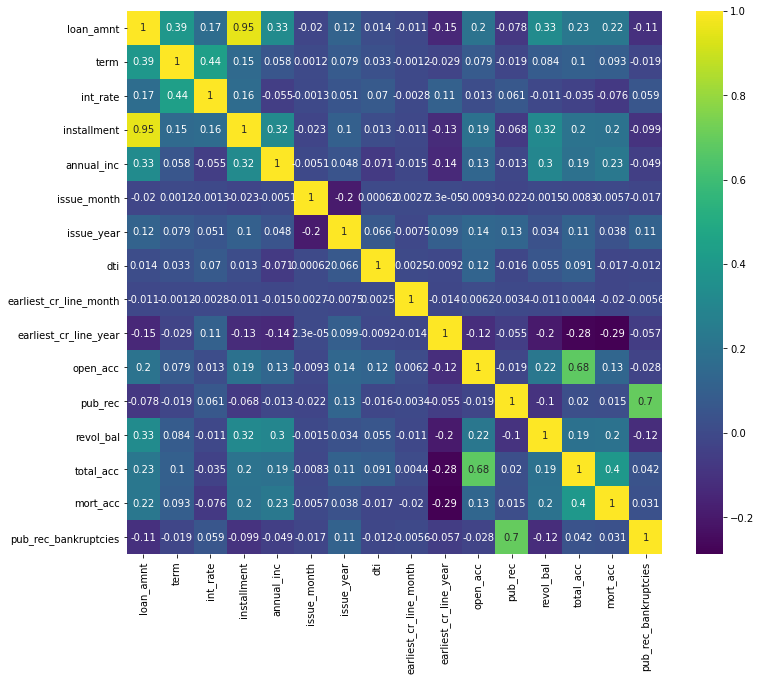

In [47]:
plt.figure(figsize=(12,10))
sns.heatmap(train.corr(), annot=True, cmap='viridis')

We can see that loan_amnt and installment have very high correlation; however, we should expect that installment is related to loan_amnt, term, and int_rate. Since we have all three of these, I will drop installment.

Otherwise, based on correlations, all other numerical columns should be kept.

In [48]:
train = train.drop('installment', axis=1)
X_valid = X_valid.drop('installment', axis=1)
X_test = X_test.drop('installment', axis=1)

In [49]:
train.head()

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_month,...,pub_rec,revol_bal,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zip_code,state,loan_status
112765,16200.0,36,14.33,C,C1,3 years,MORTGAGE,55000.0,Verified,10,...,0.0,12963.0,17.0,f,INDIVIDUAL,1.0,0.0,00813,AA,Fully Paid
385240,35000.0,60,24.50,F,F3,2 years,RENT,130000.0,Verified,5,...,0.0,29296.0,10.0,f,INDIVIDUAL,0.0,0.0,22690,NM,Fully Paid
376256,16800.0,36,14.48,C,C5,2 years,RENT,50000.0,Source Verified,12,...,0.0,14044.0,16.0,w,INDIVIDUAL,0.0,0.0,00813,IN,Fully Paid
244468,8000.0,36,10.49,B,B3,3 years,MORTGAGE,65000.0,Source Verified,12,...,0.0,1706.0,23.0,f,INDIVIDUAL,2.0,0.0,48052,IN,Fully Paid
245380,4500.0,36,9.17,B,B2,4 years,RENT,60000.0,Verified,4,...,1.0,4268.0,32.0,w,INDIVIDUAL,1.0,1.0,30723,SC,Fully Paid


It appears to me that having both grade and sub_grade could be giving us the same info. sub_grade is more detailed, but I will look into how grade and sub_grade compare to the loan_status variable to see which one may be best to keep.

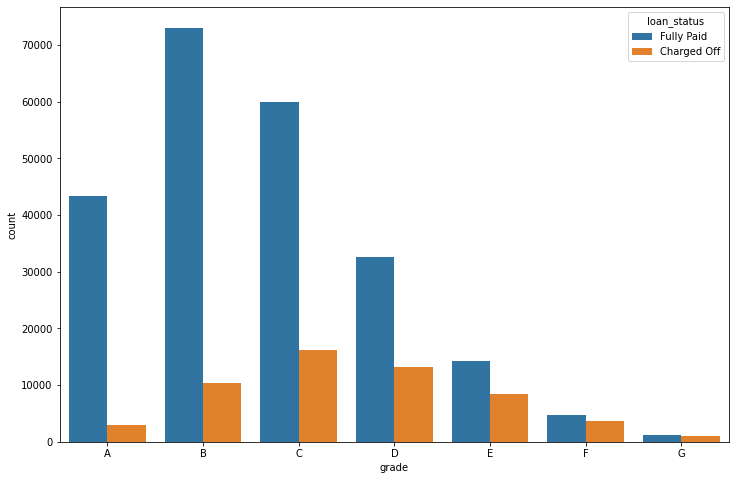

In [50]:
plt.figure(figsize=(12, 8))
grade_order = np.sort(train['grade'].unique())
sns.countplot(data=train, x='grade', hue='loan_status', order=grade_order)
plt.show()

It definitely appears as though the proportion of Charged Off increases, so grade is giving us good insight. Let's check subgrade.

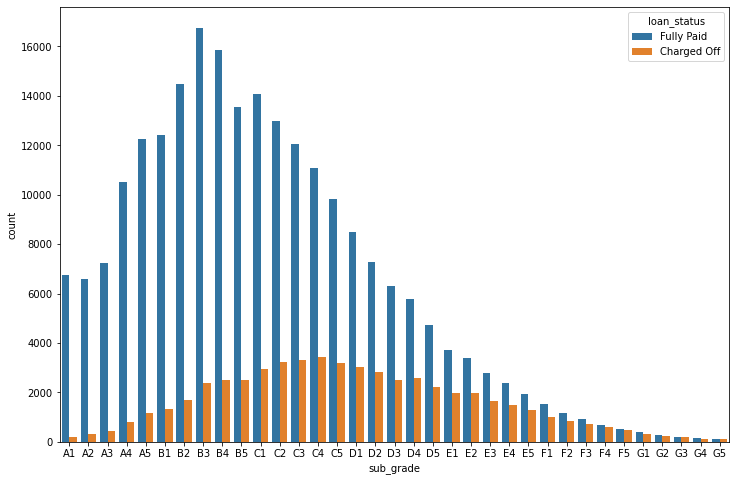

In [51]:
plt.figure(figsize=(12, 8))
subgrade_order = np.sort(train['sub_grade'].unique())
sns.countplot(data=train, x='sub_grade', hue='loan_status', order=subgrade_order)
plt.show()

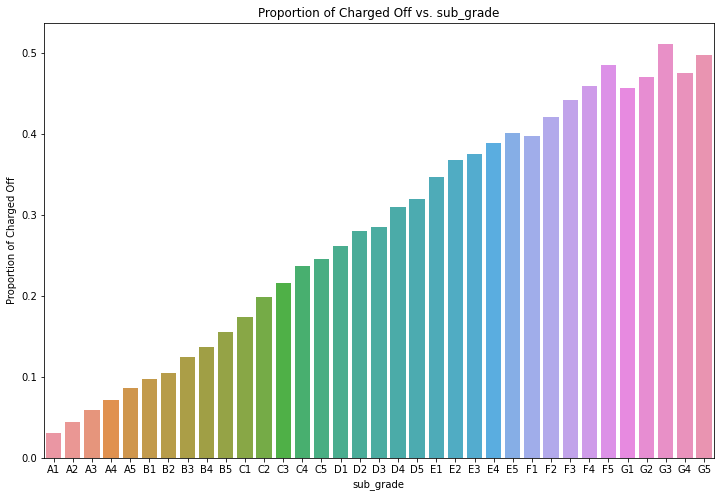

In [52]:
visualize_proportions('sub_grade', subgrade_order)

Unsurprisingly, we can clearly see a difference in individual sub_grades, so it is best to keep this and remove grade.

In [53]:
train = train.drop('grade', axis=1)
X_valid = X_valid.drop('grade', axis=1)
X_test = X_test.drop('grade', axis=1)

In [54]:
train.head()

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_month,issue_year,...,pub_rec,revol_bal,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zip_code,state,loan_status
112765,16200.0,36,14.33,C1,3 years,MORTGAGE,55000.0,Verified,10,2012,...,0.0,12963.0,17.0,f,INDIVIDUAL,1.0,0.0,00813,AA,Fully Paid
385240,35000.0,60,24.50,F3,2 years,RENT,130000.0,Verified,5,2015,...,0.0,29296.0,10.0,f,INDIVIDUAL,0.0,0.0,22690,NM,Fully Paid
376256,16800.0,36,14.48,C5,2 years,RENT,50000.0,Source Verified,12,2015,...,0.0,14044.0,16.0,w,INDIVIDUAL,0.0,0.0,00813,IN,Fully Paid
244468,8000.0,36,10.49,B3,3 years,MORTGAGE,65000.0,Source Verified,12,2014,...,0.0,1706.0,23.0,f,INDIVIDUAL,2.0,0.0,48052,IN,Fully Paid
245380,4500.0,36,9.17,B2,4 years,RENT,60000.0,Verified,4,2015,...,1.0,4268.0,32.0,w,INDIVIDUAL,1.0,1.0,30723,SC,Fully Paid


#### Emp_length and annual_inc

It could stand to reason that emp_length and annual_inc are closely related. I will look into this.

In [55]:
train['emp_length'].value_counts()

10+ years    90694
< 1 year     35920
2 years      25762
3 years      22832
5 years      19087
1 year       18647
4 years      17259
6 years      15028
7 years      14954
8 years      13859
9 years      10970
Name: emp_length, dtype: int64

In [56]:
emp_length_inc = train.groupby('emp_length').describe()['annual_inc'][['count', 'mean', 'std']]

In [57]:
emp_length_inc['mean']

emp_length
1 year       69596.438459
10+ years    81465.119112
2 years      71589.795353
3 years      73161.854396
4 years      72464.436851
5 years      73102.339527
6 years      73601.032155
7 years      73986.675058
8 years      75086.910441
9 years      75798.753304
< 1 year     61990.066302
Name: mean, dtype: float64

In [58]:
train['emp_length'].unique()

array(['3 years', '2 years', '4 years', '10+ years', '5 years', '1 year',
       '9 years', '8 years', '6 years', '< 1 year', '7 years'],
      dtype=object)

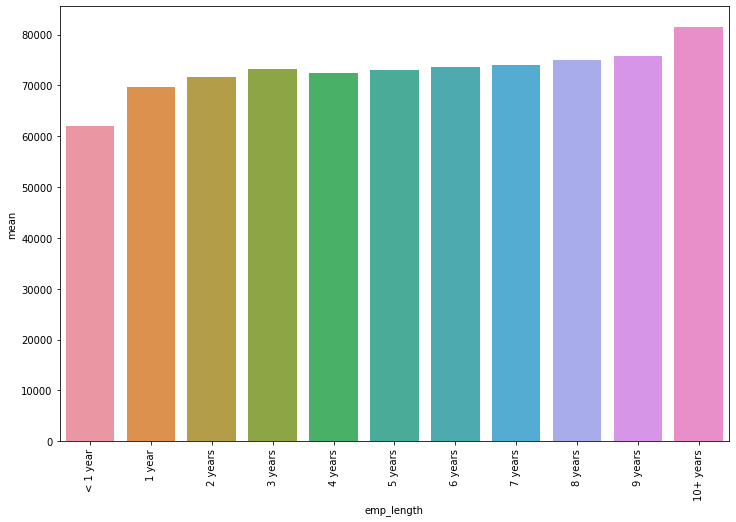

In [59]:
emp_len_order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
                 '6 years', '7 years', '8 years', '9 years', '10+ years']
plt.figure(figsize=(12, 8))
sns.barplot(data=emp_length_inc, x=emp_length_inc.index, y='mean', order=emp_len_order)
plt.xticks(rotation=90)
plt.show()

While the <1 year category is the smallest and 10+ years is the largest, there is not much separation between, so removing the emp_length based on this would not be wise.

<AxesSubplot:xlabel='emp_length', ylabel='count'>

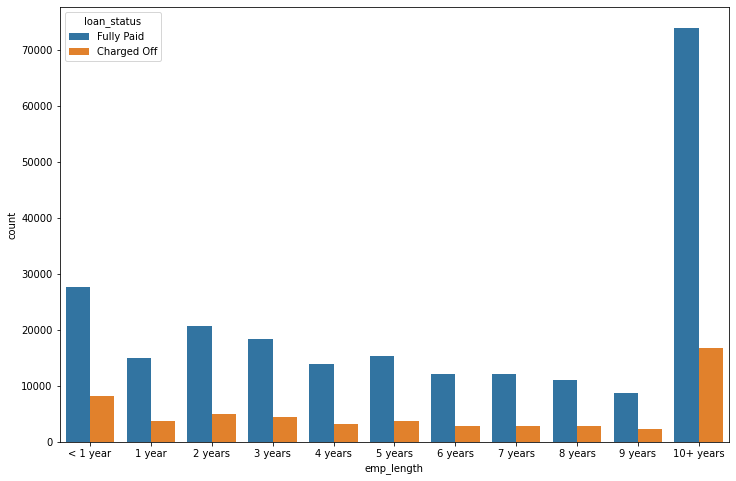

In [60]:
plt.figure(figsize=(12, 8))
sns.countplot(data=train, x='emp_length', hue='loan_status', order=emp_len_order)

The proportions above looks very close to teach other, so I will explore that further.

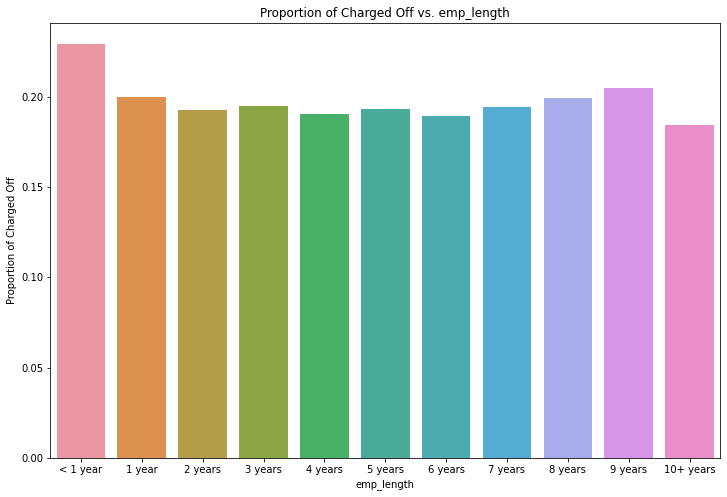

In [61]:
visualize_proportions('emp_length', emp_len_order)

The proportion of charged off does differ overall, so it is probably best to keep this feature.

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285012 entries, 112765 to 270409
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   loan_amnt               285012 non-null  float64
 1   term                    285012 non-null  int32  
 2   int_rate                285012 non-null  float64
 3   sub_grade               285012 non-null  object 
 4   emp_length              285012 non-null  object 
 5   home_ownership          285012 non-null  object 
 6   annual_inc              285012 non-null  float64
 7   verification_status     285012 non-null  object 
 8   issue_month             285012 non-null  int64  
 9   issue_year              285012 non-null  int64  
 10  purpose                 285012 non-null  object 
 11  dti                     285012 non-null  float64
 12  earliest_cr_line_month  285012 non-null  int64  
 13  earliest_cr_line_year   285012 non-null  int64  
 14  open_acc       

It seems unlikely the issue_month or earliest_cr_line_month will be useful since they are independent of year. I will look into them to see if they should be kept or not.

In [63]:
get_feature_info('issue_month')

'The month which the loan was funded (regardless of year)'

Based on this, we would not have this feature as this would be when the loan was dispersed, so the issue month and issue year features should be dropped.

In [64]:
train = train.drop('issue_month', axis=1)
X_valid = X_valid.drop('issue_month', axis=1)
X_test = X_test.drop('issue_month', axis=1)

In [65]:
train = train.drop('issue_year', axis=1)
X_valid = X_valid.drop('issue_year', axis=1)
X_test = X_test.drop('issue_year', axis=1)

<AxesSubplot:xlabel='earliest_cr_line_month', ylabel='count'>

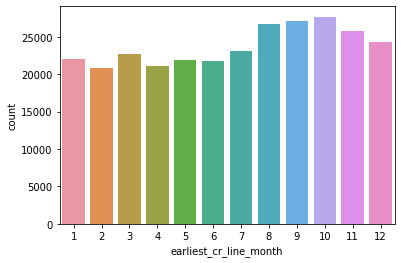

In [66]:
sns.countplot(data=train, x='earliest_cr_line_month')

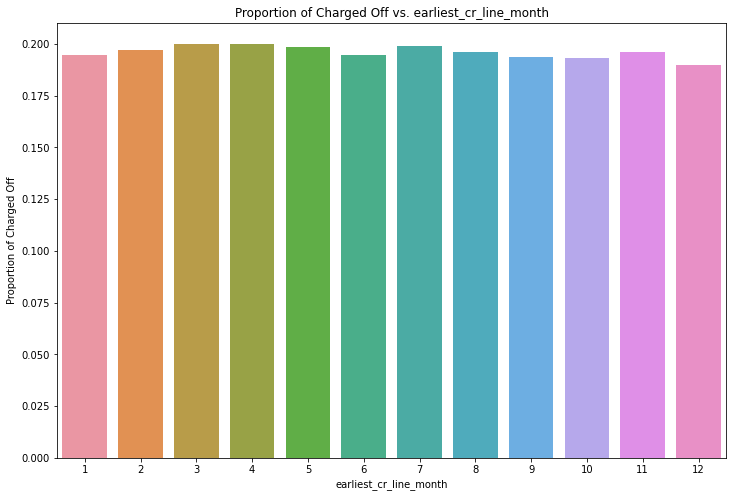

In [67]:
visualize_proportions('earliest_cr_line_month')

The earliest_cr_line_month is very steady as well, so I will also drop this feature.

In [68]:
train = train.drop('earliest_cr_line_month', axis=1)
X_valid = X_valid.drop('earliest_cr_line_month', axis=1)
X_test = X_test.drop('earliest_cr_line_month', axis=1)

I will now explore the earliest_cr_line_year feature.

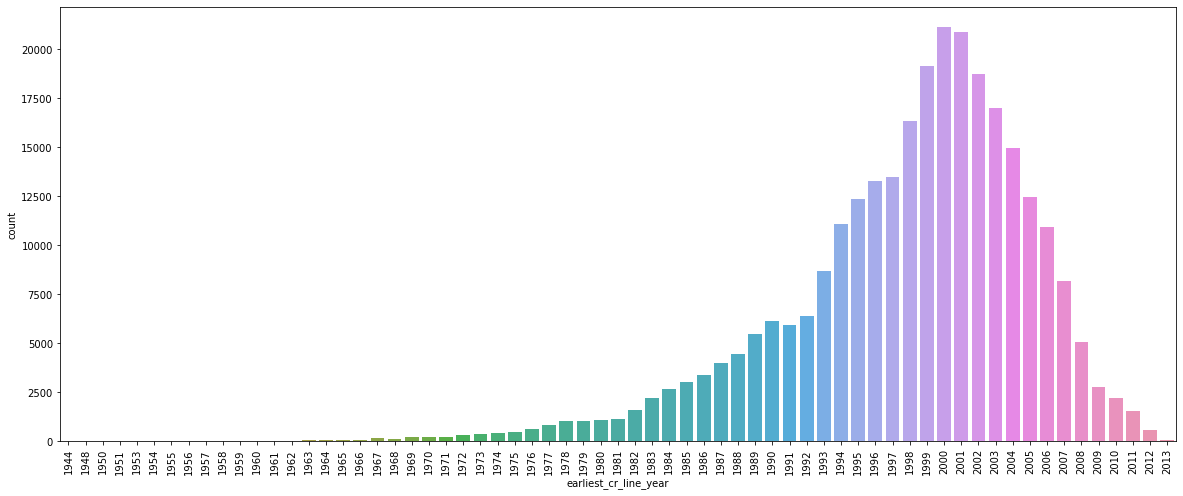

In [69]:
plt.figure(figsize=(20, 8))

sns.countplot(data=train, x='earliest_cr_line_year')
plt.xticks(rotation=90)
plt.show()

There is quite a range of years here. One thing to note is prior to ~1970, the numbers are very close to zero, so I will visualize proportions.

Additionally, since a model could be ran in the future, it is probably better to use a "years since" instead of using the year of. This dataset was compiled in 2018, so I will create new feature "years_since_first_cr_line".

In [70]:
train['years_since_first_cr_line'] = 2018 - train['earliest_cr_line_year']
X_valid['years_since_first_cr_line'] = 2018 - X_valid['earliest_cr_line_year']
X_test['years_since_first_cr_line'] = 2018 - X_test['earliest_cr_line_year']

In [71]:
train = train.drop('earliest_cr_line_year', axis=1)
X_valid = X_valid.drop('earliest_cr_line_year', axis=1)
X_test = X_test.drop('earliest_cr_line_year', axis=1)

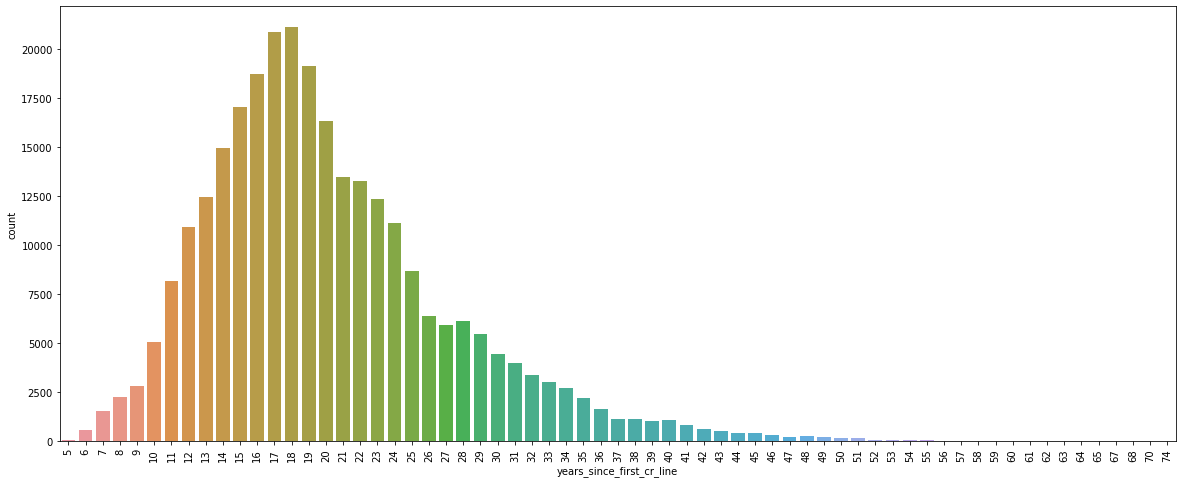

In [72]:
plt.figure(figsize=(20, 8))

sns.countplot(data=train, x='years_since_first_cr_line')
plt.xticks(rotation=90)
plt.show()

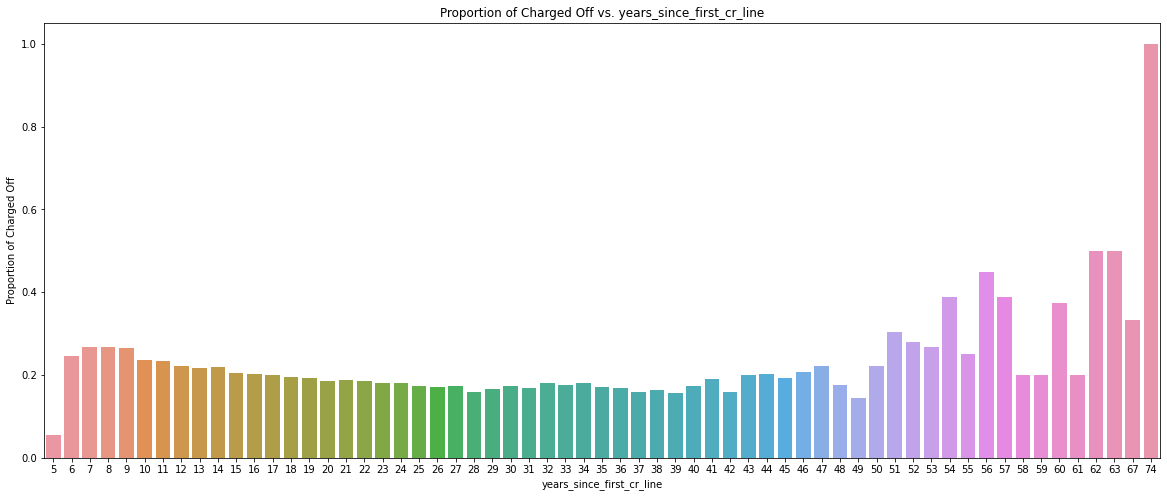

In [73]:
visualize_proportions('years_since_first_cr_line', figsize=(20, 8))

Since the most data for years_since_first_cr_line occurs between 10 and 30, and there does seem to be a downward trend, even ever so slightly, I will keep this feature.

In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285012 entries, 112765 to 270409
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_amnt                  285012 non-null  float64
 1   term                       285012 non-null  int32  
 2   int_rate                   285012 non-null  float64
 3   sub_grade                  285012 non-null  object 
 4   emp_length                 285012 non-null  object 
 5   home_ownership             285012 non-null  object 
 6   annual_inc                 285012 non-null  float64
 7   verification_status        285012 non-null  object 
 8   purpose                    285012 non-null  object 
 9   dti                        285012 non-null  float64
 10  open_acc                   285012 non-null  float64
 11  pub_rec                    285012 non-null  float64
 12  revol_bal                  285012 non-null  float64
 13  total_acc               

#### zip_code and state

<AxesSubplot:xlabel='zip_code', ylabel='count'>

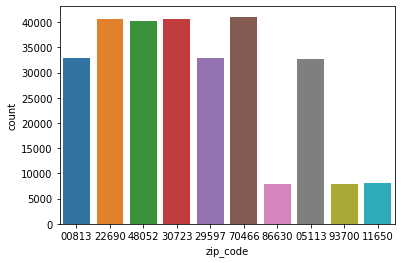

In [75]:
sns.countplot(data=train, x='zip_code')

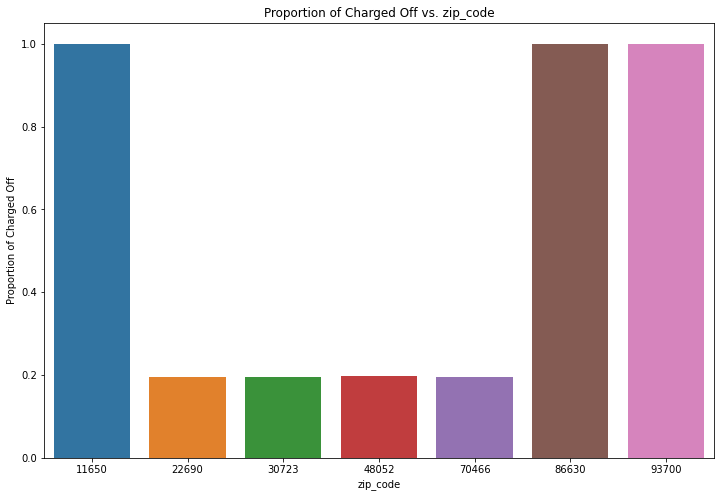

In [76]:
visualize_proportions('zip_code')

We can see that there are 3 zip codes with all being charged off, 4 around 20%, and the 3 missing are because it is at 0%. Thus, this feature is useful. However, zip_code is definitely not a numerical feature (no ordering), and since there is only 10 zip codes, we would be restricting the model to only using one of these zip_codes in the future. Thus, it should not be used.

In [77]:
# train = train.drop('zip_code', axis=1)
# X_valid = X_valid.drop('zip_code', axis=1)
# X_test = X_test.drop('zip_code', axis=1)

<AxesSubplot:xlabel='state', ylabel='count'>

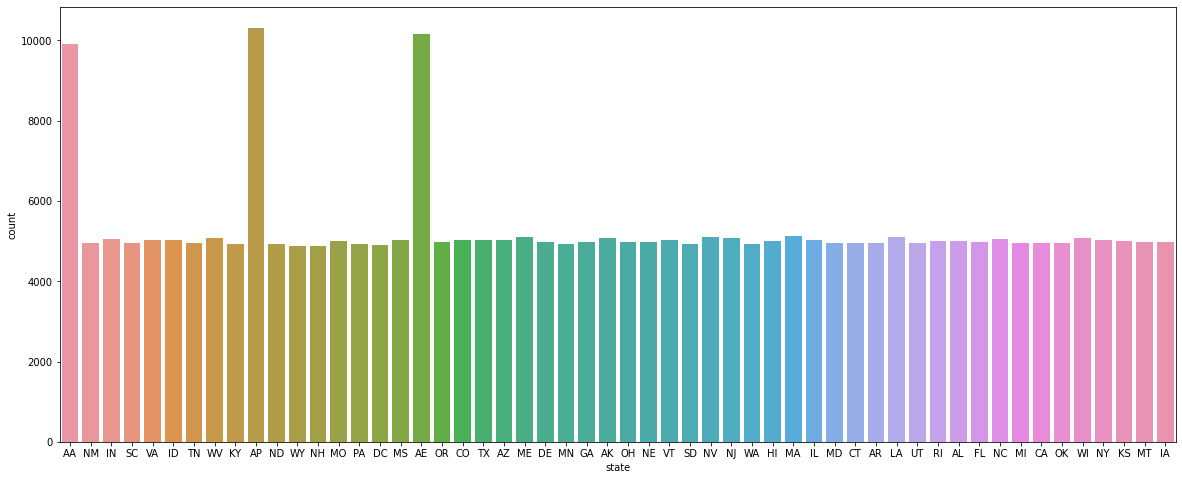

In [78]:
plt.figure(figsize=(20, 8))
sns.countplot(data=train, x='state')

Given the vastly different populations of different states, this data seems odd in the least. However, I will look further into the proportions.

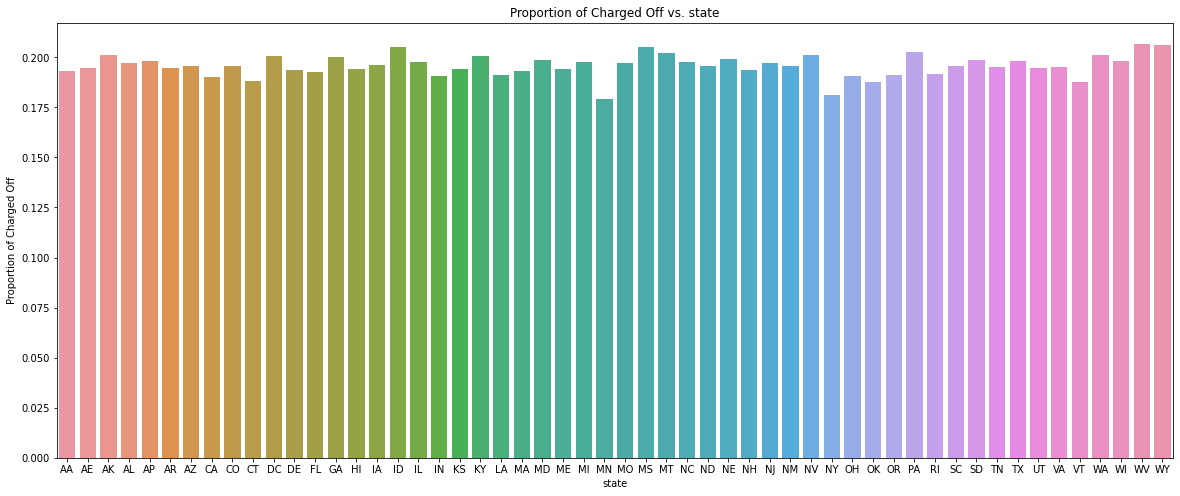

In [79]:
visualize_proportions('state', figsize=(20,8))

With so many features and the proportions of charged off being all being rather similar, I will remove this feature as well.

In [80]:
train = train.drop('state', axis=1)
X_valid = X_valid.drop('state', axis=1)
X_test = X_test.drop('state', axis=1)

#### home_ownership, verification_status, purpose, initial_list_status, and application_type

In [81]:
get_feature_info('home_ownership')

'The home ownership status provided by the borrower during registration\xa0or obtained from the credit report.\xa0Our values are: RENT, OWN, MORTGAGE, OTHER'

In [82]:
train['home_ownership'].value_counts()

MORTGAGE    142506
RENT        115327
OWN          27068
OTHER          111
Name: home_ownership, dtype: int64

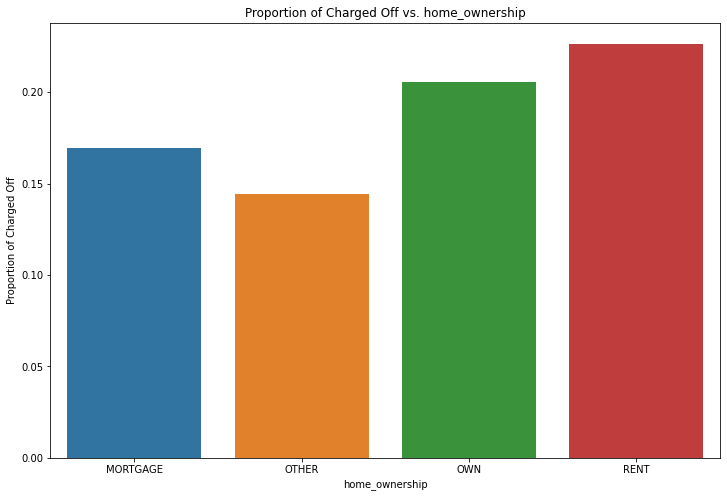

In [83]:
visualize_proportions('home_ownership')

The home_ownership feature definitely looks useful.

In [84]:
get_feature_info('verification_status')

'Indicates if income was verified by LC, not verified, or if the income source was verified'

In [85]:
train['verification_status'].value_counts()

Verified           100402
Source Verified     94324
Not Verified        90286
Name: verification_status, dtype: int64

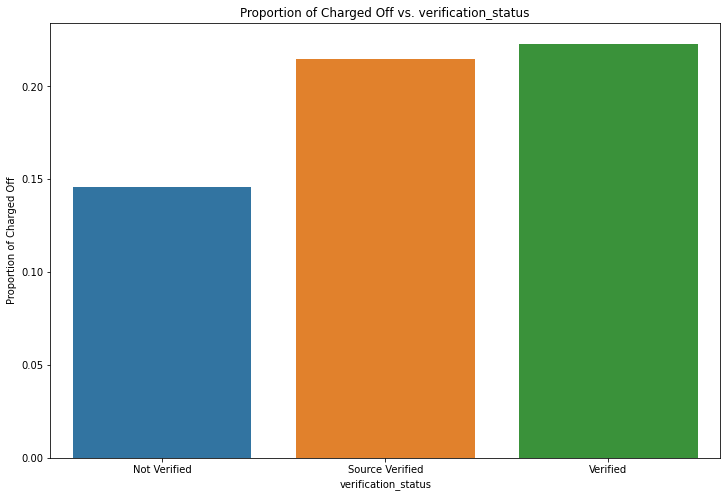

In [86]:
visualize_proportions('verification_status')

Verification status also looks useful.

In [87]:
get_feature_info('purpose')

'A category provided by the borrower for the loan request. '

In [88]:
train['purpose'].value_counts()

debt_consolidation    168742
credit_card            59836
home_improvement       17349
other                  15223
major_purchase          6281
small_business          4123
car                     3338
medical                 3008
moving                  2071
vacation                1725
house                   1580
wedding                 1314
renewable_energy         246
educational              176
Name: purpose, dtype: int64

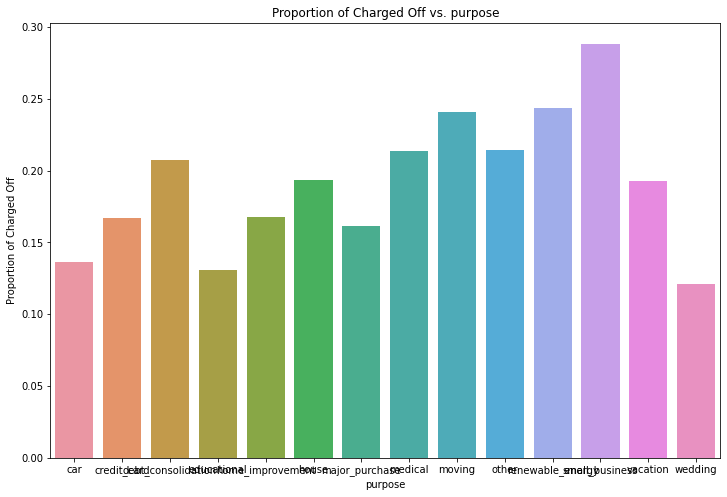

In [89]:
visualize_proportions('purpose')

We can see this feature has quite a varied proportion distribution as well. Even though there are quite a few different features, I think it should be kept.

In [90]:
get_feature_info('initial_list_status')

'The initial listing status of the loan. Possible values are – W, F'

In [91]:
train['initial_list_status'].value_counts()

f    171375
w    113637
Name: initial_list_status, dtype: int64

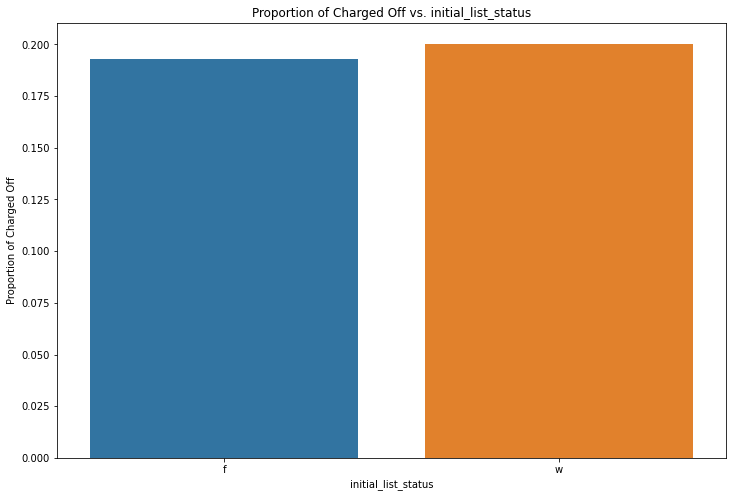

In [92]:
visualize_proportions('initial_list_status')

Very similar proportions, but with only 2 features, I will keep it.

In [93]:
get_feature_info('application_type')

'Indicates whether the loan is an individual application or a joint application with two co-borrowers'

In [94]:
train['application_type'].value_counts()

INDIVIDUAL    284499
JOINT            302
DIRECT_PAY       211
Name: application_type, dtype: int64

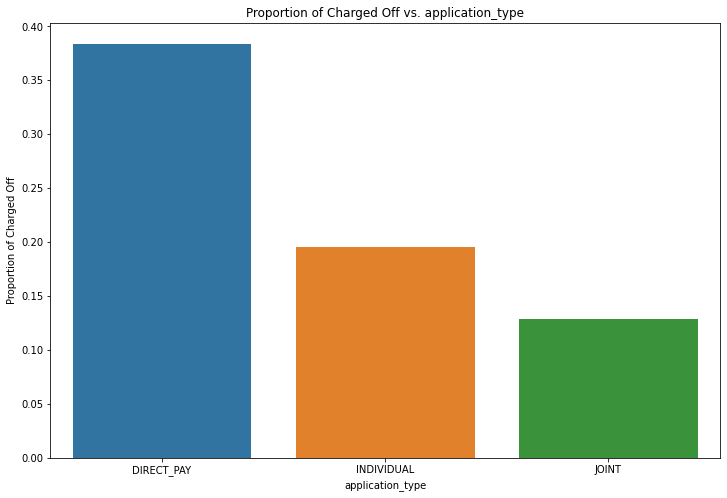

In [95]:
visualize_proportions('application_type')

Even though over 99% of the application types are individual, there is such a higher proportion of charged off for direct_pay and lower proportion for joint, that I think it would be worth keeping as is.

In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285012 entries, 112765 to 270409
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_amnt                  285012 non-null  float64
 1   term                       285012 non-null  int32  
 2   int_rate                   285012 non-null  float64
 3   sub_grade                  285012 non-null  object 
 4   emp_length                 285012 non-null  object 
 5   home_ownership             285012 non-null  object 
 6   annual_inc                 285012 non-null  float64
 7   verification_status        285012 non-null  object 
 8   purpose                    285012 non-null  object 
 9   dti                        285012 non-null  float64
 10  open_acc                   285012 non-null  float64
 11  pub_rec                    285012 non-null  float64
 12  revol_bal                  285012 non-null  float64
 13  total_acc               

In [97]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71254 entries, 228155 to 337349
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   loan_amnt                  71254 non-null  float64
 1   term                       71254 non-null  int32  
 2   int_rate                   71254 non-null  float64
 3   sub_grade                  71254 non-null  object 
 4   emp_length                 71254 non-null  object 
 5   home_ownership             71254 non-null  object 
 6   annual_inc                 71254 non-null  float64
 7   verification_status        71254 non-null  object 
 8   purpose                    71254 non-null  object 
 9   dti                        71254 non-null  float64
 10  open_acc                   71254 non-null  float64
 11  pub_rec                    71254 non-null  float64
 12  revol_bal                  71254 non-null  float64
 13  total_acc                  71254 non-nul

In [98]:
X_train = train.drop('loan_status', axis=1)
y_train = train['loan_status']

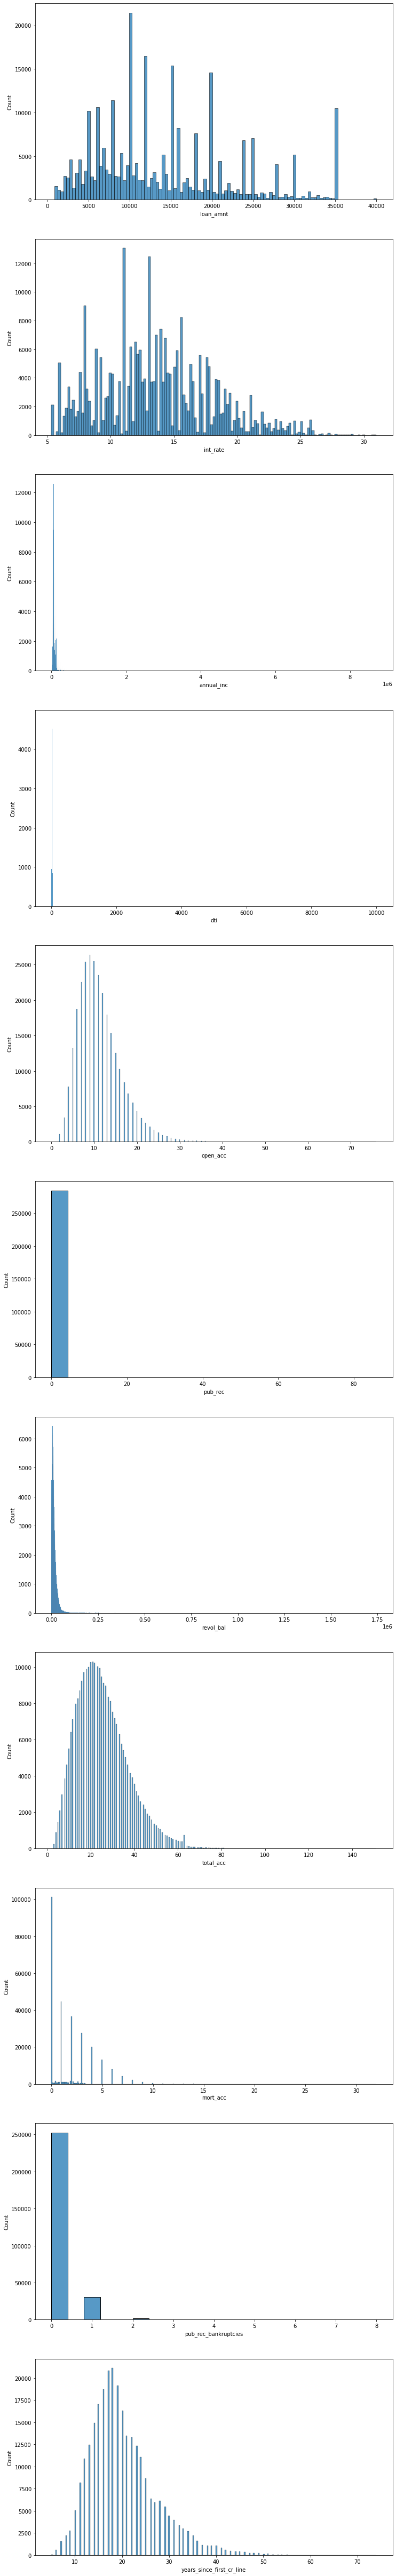

In [100]:
num_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal',
            'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'years_since_first_cr_line']

N = len(num_cols)

fig, ax = plt.subplots(nrows=N, figsize=(12, 8*N))

i = 0

for col in num_cols:
    sns.histplot(data=X_train, x=col, ax=ax[i])
    i += 1

For scaling the numerical data for the model, it may be best to use MinMaxScaler.

For the categorical data, OneHotEncoder would work for all categorical features.

# Final Model Prep

First, convert the y column to 0 and 1: Fully Paid --> 0, Charged Off --> 1

In [101]:
target_map = {'Fully Paid': 0, 'Charged Off': 1}

y_train = y_train.map(target_map).rename('Loan Charged Off')
y_valid = y_valid.map(target_map).rename('Loan Charged Off')
y_test = y_test.map(target_map).rename('Loan Charged Off')

In [275]:
onehot = OneHotEncoder()
scaler = MinMaxScaler()

preprocessing_nn = ColumnTransformer([
    ('nums', scaler, X_train.select_dtypes(include='number').columns),
    ('cats', onehot, X_train.select_dtypes(exclude='number').columns)
])

In [103]:
X_train_trans = preprocessing.fit_transform(X_train).toarray()
X_valid_trans = preprocessing.transform(X_valid).toarray()
X_test_trans = preprocessing.transform(X_test).toarray()

In [104]:
X_train_trans.shape

(285012, 94)

# Model Creation

### NN (full feature set)

In [105]:
# exp decay function for learning rate
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch/s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [118]:
# callbacks

lr_scheduler = LearningRateScheduler(exponential_decay_fn)
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10)

callbacks = [lr_scheduler, early_stop]

In [127]:
# model

model = Sequential()

model.add(Dense(94, activation='elu', kernel_initializer='he_normal')) # input layer
model.add(Dense(47, activation='elu', kernel_initializer='he_normal')) # hidden layer 1
model.add(Dropout(rate=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision()])

In [128]:
model.fit(x=X_train_trans, y=y_train, epochs=50, batch_size=256,
          validation_data=(X_valid_trans, y_valid), verbose=1,
          callbacks=callbacks)

Epoch 1/50
1114/1114 [==============================] - 2s 2ms/step - loss: 0.2708 - accuracy: 0.8853 - precision_4: 0.9179 - val_loss: 0.2638 - val_accuracy: 0.8882 - val_precision_4: 1.0000
Epoch 2/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2630 - accuracy: 0.8876 - precision_4: 0.9474 - val_loss: 0.2610 - val_accuracy: 0.8872 - val_precision_4: 0.9057
Epoch 3/50
1114/1114 [==============================] - 2s 2ms/step - loss: 0.2621 - accuracy: 0.8878 - precision_4: 0.9474 - val_loss: 0.2637 - val_accuracy: 0.8883 - val_precision_4: 0.9286
Epoch 4/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2615 - accuracy: 0.8879 - precision_4: 0.9448 - val_loss: 0.2607 - val_accuracy: 0.8882 - val_precision_4: 0.9998
Epoch 5/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2609 - accuracy: 0.8879 - precision_4: 0.9442 - val_loss: 0.2592 - val_accuracy: 0.8883 - val_precision_4: 0.9895
Epoch 6/50
1114/1114 [==================

<AxesSubplot:>

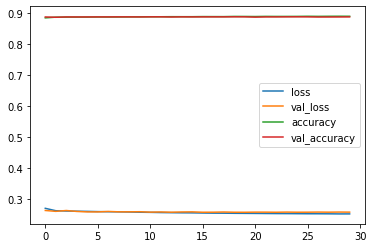

In [129]:
losses_full = pd.DataFrame(model.history.history)

losses_full[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot()

In [161]:
losses_full['val_accuracy'].sort_values(ascending=False)[:5].mean() # mean of 5 highest val accuracies

0.8886406421661377

### NN (without zip-code)

In [137]:
# get rid of zip_code
X_train_no_zip = X_train.drop('zip_code', axis=1)
X_valid_no_zip = X_valid.drop('zip_code', axis=1)
X_test_no_zip = X_test.drop('zip_code', axis=1)

# new preprocessing
scaler = MinMaxScaler()
onehot = OneHotEncoder()

preprocessing_no_zip = ColumnTransformer([
    ('nums', scaler, X_train_no_zip.select_dtypes(include='number').columns),
    ('objs', onehot, X_train_no_zip.select_dtypes(exclude='number').columns)
])

X_train_no_zip = preprocessing_no_zip.fit_transform(X_train_no_zip).toarray()
X_valid_no_zip = preprocessing_no_zip.transform(X_valid_no_zip).toarray()
X_test_no_zip = preprocessing_no_zip.transform(X_test_no_zip).toarray()

In [140]:
X_train_no_zip.shape

(285012, 84)

In [141]:
# model

model_no_zip = Sequential()

model_no_zip.add(Dense(84, activation='elu', kernel_initializer='he_normal')) # input layer
model_no_zip.add(Dense(42, activation='elu', kernel_initializer='he_normal')) # hidden layer 1
model_no_zip.add(Dropout(rate=0.25))
model_no_zip.add(Dense(1, activation='sigmoid'))

model_no_zip.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision()])

In [142]:
model_no_zip.fit(x=X_train_no_zip, y=y_train, epochs=50, batch_size=256,
          validation_data=(X_valid_no_zip, y_valid), verbose=1,
          callbacks=callbacks)

Epoch 1/50
1114/1114 [==============================] - 2s 2ms/step - loss: 0.4605 - accuracy: 0.8034 - precision_7: 0.4762 - val_loss: 0.4570 - val_accuracy: 0.8032 - val_precision_7: 0.4927
Epoch 2/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.4572 - accuracy: 0.8040 - precision_7: 0.4945 - val_loss: 0.4570 - val_accuracy: 0.8037 - val_precision_7: 0.5219
Epoch 3/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.4562 - accuracy: 0.8039 - precision_7: 0.4915 - val_loss: 0.4551 - val_accuracy: 0.8037 - val_precision_7: 0.5073
Epoch 4/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.4554 - accuracy: 0.8041 - precision_7: 0.4977 - val_loss: 0.4554 - val_accuracy: 0.8027 - val_precision_7: 0.4909
Epoch 5/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.4546 - accuracy: 0.8038 - precision_7: 0.4878 - val_loss: 0.4541 - val_accuracy: 0.8039 - val_precision_7: 0.5242
Epoch 6/50
1114/1114 [==================

1114/1114 [==============================] - 2s 2ms/step - loss: 0.4451 - accuracy: 0.8071 - precision_7: 0.5551 - val_loss: 0.4508 - val_accuracy: 0.8054 - val_precision_7: 0.5405
Epoch 44/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.4450 - accuracy: 0.8075 - precision_7: 0.5626 - val_loss: 0.4509 - val_accuracy: 0.8052 - val_precision_7: 0.5369
Epoch 45/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.4451 - accuracy: 0.8070 - precision_7: 0.5539 - val_loss: 0.4509 - val_accuracy: 0.8052 - val_precision_7: 0.5364


<AxesSubplot:>

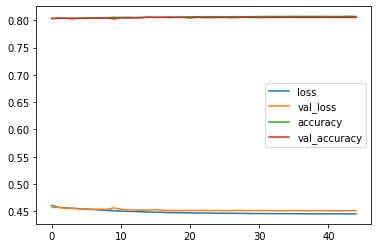

In [145]:
losses_no_zip = pd.DataFrame(model_no_zip.history.history)

losses_no_zip[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot()

In [160]:
losses_no_zip['val_accuracy'].sort_values(ascending=False)[:5].mean() # mean of 5 highest val accuracies

0.8055379390716553

In [158]:
df.groupby('loan_status').size()['Fully Paid'] / df.shape[0] * 100

80.3916615300668

The original dataset had about 80.4% Fully Paid. Without the zip_code, we are not doing any better than just guessing 'Fully Paid' every time. (80.5% to 80.4%).

Given that we did so much better with the zip_code added in, it may be the case that many of these features are not needed.

For experimentation, I want to see how it does without 'purpose' as that feature has some differing proportions as well.

## NN (without purpose)

In [146]:
# get rid of purpose
X_train_no_purpose = X_train.drop('purpose', axis=1)
X_valid_no_purpose = X_valid.drop('purpose', axis=1)
X_test_no_purpose = X_test.drop('purpose', axis=1)

# new preprocessing
scaler = MinMaxScaler()
onehot = OneHotEncoder()

preprocessing_no_purpose = ColumnTransformer([
    ('nums', scaler, X_train_no_purpose.select_dtypes(include='number').columns),
    ('objs', onehot, X_train_no_purpose.select_dtypes(exclude='number').columns)
])

X_train_no_purpose = preprocessing_no_purpose.fit_transform(X_train_no_purpose).toarray()
X_valid_no_purpose = preprocessing_no_purpose.transform(X_valid_no_purpose).toarray()
X_test_no_purpose = preprocessing_no_purpose.transform(X_test_no_purpose).toarray()

In [147]:
X_train_no_purpose.shape

(285012, 80)

In [148]:
# model

model_no_purpose = Sequential()

model_no_purpose.add(Dense(84, activation='elu', kernel_initializer='he_normal')) # input layer
model_no_purpose.add(Dense(42, activation='elu', kernel_initializer='he_normal')) # hidden layer 1
model_no_purpose.add(Dropout(rate=0.25))
model_no_purpose.add(Dense(1, activation='sigmoid'))

model_no_purpose.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision()])

In [150]:
model_no_purpose.fit(x=X_train_no_purpose, y=y_train, epochs=50, batch_size=256,
          validation_data=(X_valid_no_purpose, y_valid), verbose=1,
          callbacks=callbacks)

Epoch 1/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2696 - accuracy: 0.8856 - precision_8: 0.9166 - val_loss: 0.2607 - val_accuracy: 0.8885 - val_precision_8: 0.9901
Epoch 2/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2627 - accuracy: 0.8875 - precision_8: 0.9472 - val_loss: 0.2670 - val_accuracy: 0.8887 - val_precision_8: 0.9627
Epoch 3/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2620 - accuracy: 0.8877 - precision_8: 0.9492 - val_loss: 0.2613 - val_accuracy: 0.8884 - val_precision_8: 0.9630
Epoch 4/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2612 - accuracy: 0.8880 - precision_8: 0.9490 - val_loss: 0.2601 - val_accuracy: 0.8882 - val_precision_8: 0.9896
Epoch 5/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2607 - accuracy: 0.8879 - precision_8: 0.9484 - val_loss: 0.2590 - val_accuracy: 0.8880 - val_precision_8: 0.9547
Epoch 6/50
1114/1114 [==================

1114/1114 [==============================] - 2s 1ms/step - loss: 0.2539 - accuracy: 0.8899 - precision_8: 0.9337 - val_loss: 0.2573 - val_accuracy: 0.8886 - val_precision_8: 0.9240
Epoch 44/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2540 - accuracy: 0.8899 - precision_8: 0.9315 - val_loss: 0.2573 - val_accuracy: 0.8888 - val_precision_8: 0.9291
Epoch 45/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2539 - accuracy: 0.8898 - precision_8: 0.9313 - val_loss: 0.2574 - val_accuracy: 0.8888 - val_precision_8: 0.9329
Epoch 46/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2538 - accuracy: 0.8901 - precision_8: 0.9323 - val_loss: 0.2573 - val_accuracy: 0.8889 - val_precision_8: 0.9266
Epoch 47/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2540 - accuracy: 0.8898 - precision_8: 0.9316 - val_loss: 0.2573 - val_accuracy: 0.8887 - val_precision_8: 0.9240
Epoch 48/50
1114/1114 [========================

<AxesSubplot:>

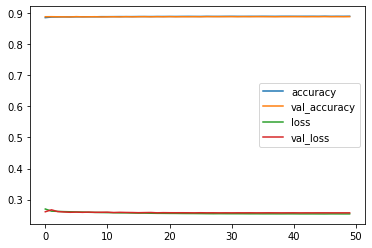

In [162]:
losses_no_purpose = pd.DataFrame(model_no_purpose.history.history)

losses_no_purpose[['accuracy', 'val_accuracy', 'loss', 'val_loss']].plot()

In [163]:
losses_no_purpose['val_accuracy'].sort_values(ascending=False)[:5].mean() # mean of 5 highest val accuracies

0.8889325618743896

By removing only the purpose column there was no loss in validation accuracy. This could indicate, especially from the observation above, that many features are not adding any value.

Of note are initial_list_status and application_type. initial_list_status was rather balanced vs the loan_status and application_type was almost one entire feature. I will remove these two as well to see how the model performs.

## NN (no purpose, initial_list_status, or application_type)

In [164]:
# get rid of feats
feats_to_remove = ['purpose', 'initial_list_status', 'application_type']

X_train_no_feats = X_train.drop(feats_to_remove, axis=1)
X_valid_no_feats = X_valid.drop(feats_to_remove, axis=1)
X_test_no_feats = X_test.drop(feats_to_remove, axis=1)

# new preprocessing
scaler = MinMaxScaler()
onehot = OneHotEncoder()

preprocessing_no_feats = ColumnTransformer([
    ('nums', scaler, X_train_no_feats.select_dtypes(include='number').columns),
    ('objs', onehot, X_train_no_feats.select_dtypes(exclude='number').columns)
])

X_train_no_feats = preprocessing_no_feats.fit_transform(X_train_no_feats).toarray()
X_valid_no_feats = preprocessing_no_feats.transform(X_valid_no_feats).toarray()
X_test_no_feats = preprocessing_no_feats.transform(X_test_no_feats).toarray()

In [165]:
X_train_no_feats.shape

(285012, 75)

In [166]:
# model

model_no_feats = Sequential()

model_no_feats.add(Dense(75, activation='elu', kernel_initializer='he_normal')) # input layer
model_no_feats.add(Dense(38, activation='elu', kernel_initializer='he_normal')) # hidden layer 1
model_no_feats.add(Dropout(rate=0.25))
model_no_feats.add(Dense(1, activation='sigmoid'))

model_no_feats.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision()])

In [167]:
model_no_feats.fit(x=X_train_no_feats, y=y_train, epochs=50, batch_size=256,
          validation_data=(X_valid_no_feats, y_valid), verbose=1,
          callbacks=callbacks)

Epoch 1/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2697 - accuracy: 0.8852 - precision_9: 0.9167 - val_loss: 0.2651 - val_accuracy: 0.8882 - val_precision_9: 0.9584
Epoch 2/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2627 - accuracy: 0.8879 - precision_9: 0.9469 - val_loss: 0.2609 - val_accuracy: 0.8880 - val_precision_9: 0.9637
Epoch 3/50
1114/1114 [==============================] - 2s 2ms/step - loss: 0.2616 - accuracy: 0.8878 - precision_9: 0.9501 - val_loss: 0.2607 - val_accuracy: 0.8885 - val_precision_9: 0.9642
Epoch 4/50
1114/1114 [==============================] - 2s 2ms/step - loss: 0.2610 - accuracy: 0.8882 - precision_9: 0.9494 - val_loss: 0.2596 - val_accuracy: 0.8882 - val_precision_9: 0.9612
Epoch 5/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2604 - accuracy: 0.8881 - precision_9: 0.9501 - val_loss: 0.2635 - val_accuracy: 0.8823 - val_precision_9: 0.8014
Epoch 6/50
1114/1114 [==================

1114/1114 [==============================] - 2s 1ms/step - loss: 0.2542 - accuracy: 0.8895 - precision_9: 0.9339 - val_loss: 0.2573 - val_accuracy: 0.8886 - val_precision_9: 0.9277
Epoch 44/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2543 - accuracy: 0.8895 - precision_9: 0.9322 - val_loss: 0.2574 - val_accuracy: 0.8884 - val_precision_9: 0.9219
Epoch 45/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2543 - accuracy: 0.8895 - precision_9: 0.9324 - val_loss: 0.2573 - val_accuracy: 0.8888 - val_precision_9: 0.9318
Epoch 46/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2542 - accuracy: 0.8896 - precision_9: 0.9322 - val_loss: 0.2573 - val_accuracy: 0.8888 - val_precision_9: 0.9302
Epoch 47/50
1114/1114 [==============================] - 2s 1ms/step - loss: 0.2542 - accuracy: 0.8894 - precision_9: 0.9318 - val_loss: 0.2573 - val_accuracy: 0.8887 - val_precision_9: 0.9283
Epoch 48/50
1114/1114 [========================

<AxesSubplot:>

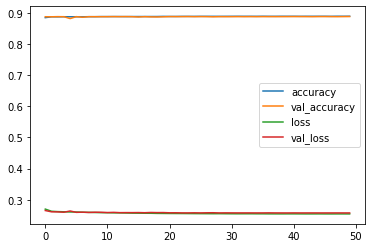

In [168]:
losses_no_feats = pd.DataFrame(model_no_feats.history.history)

losses_no_feats[['accuracy', 'val_accuracy', 'loss', 'val_loss']].plot()

In [169]:
losses_no_feats['val_accuracy'].sort_values(ascending=False)[:5].mean() # mean of 5 highest val accuracies

0.8887669324874878

### XGB

In [205]:
# base model
xgbc = xgb.XGBClassifier()

# preprocessing (don't need to scale for tree methods)
onehot = OneHotEncoder(handle_unknown='ignore')

preprocessing = ColumnTransformer([
    ('objs', onehot, X_train.select_dtypes(exclude='number').columns)],
    remainder='passthrough')
    
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('xgbc', xgbc)
])

param_grid = {
    'xgbc__n_estimators': [50, 100],
    'xgbc__use_label_encoder': [False],
    'xgbc__max_depth': [4, 8],
    'xgbc__booster': ['gbtree'],
    'xgbc__subsample': [0.25, 0.75],
    'xgbc__colsample_bytree': [0.25, 0.75]    
}

xgbc_model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=2, scoring='accuracy')

In [206]:
xgbc_model.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[17:22:39] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.25, xgbc__max_depth=4, xgbc__n_estimators=50, xgbc__subsample=0.25, xgbc__use_label_encoder=False; total time=   3.3s
[17:22:42] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.25, xgbc__max_depth=4, xgbc__n_estimators=50, xgbc__subsample=0.25, xgbc__use_label_encoder=False; total time=   3.4s
[17:22:45] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default eval

[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.25, xgbc__max_depth=4, xgbc__n_estimators=100, xgbc__subsample=0.75, xgbc__use_label_encoder=False; total time=   6.9s
[17:24:32] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.25, xgbc__max_depth=8, xgbc__n_estimators=50, xgbc__subsample=0.25, xgbc__use_label_encoder=False; total time=   5.4s
[17:24:38] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.25, xgbc__max_depth=8, xgbc__n_estimators=50, xgbc__subsample=0.25, xgbc__use_label_encoder

[17:27:10] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.25, xgbc__max_depth=8, xgbc__n_estimators=100, xgbc__subsample=0.75, xgbc__use_label_encoder=False; total time=  11.7s
[17:27:22] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.75, xgbc__max_depth=4, xgbc__n_estimators=50, xgbc__subsample=0.25, xgbc__use_label_encoder=False; total time=   4.7s
[17:27:27] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was 

[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.75, xgbc__max_depth=4, xgbc__n_estimators=100, xgbc__subsample=0.75, xgbc__use_label_encoder=False; total time=  10.4s
[17:29:42] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.75, xgbc__max_depth=4, xgbc__n_estimators=100, xgbc__subsample=0.75, xgbc__use_label_encoder=False; total time=  10.5s
[17:29:53] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.75, xgbc__max_depth=8, xgbc__n_estimators=50, xgbc__subsample=0.25, xgbc__use_label_encode

[18:42:35] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.75, xgbc__max_depth=8, xgbc__n_estimators=100, xgbc__subsample=0.75, xgbc__use_label_encoder=False; total time=  22.0s
[18:42:57] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.75, xgbc__max_depth=8, xgbc__n_estimators=100, xgbc__subsample=0.75, xgbc__use_label_encoder=False; total time=  20.6s
[18:43:17] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('objs',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['sub_grade', 'emp_length', 'home_ownership', 'verification_status',
       'purpose', 'initial_list_status', 'application_type', 'zip_code'],
      dtype='object'))])),
                                       ('xgbc',
                                        XGBClassifier(base_score...
                                                      reg_alpha=None,
                                                      reg_lambda=None,
                                                      scale_pos_weight=None,
                                                      subsample=

In [207]:
xgbc_model.best_params_

{'xgbc__booster': 'gbtree',
 'xgbc__colsample_bytree': 0.25,
 'xgbc__max_depth': 4,
 'xgbc__n_estimators': 50,
 'xgbc__subsample': 0.75,
 'xgbc__use_label_encoder': False}

In [208]:
np.mean(np.sort(xgbc_model.cv_results_['mean_test_score'])[-5:])

0.8891829148704724

As we can see, the XGB classifier does just as well as the NN above, as expected.

A benefit of the xgbc_model, though, is we get a feature_importance

In [210]:
xgbc_model.best_estimator_[-1].feature_importances_

array([5.0047832e-03, 9.1152322e-03, 6.3370625e-03, 8.3377641e-03,
       5.4875398e-03, 1.1235048e-02, 1.2427633e-02, 6.4232312e-03,
       9.1357797e-04, 1.4342398e-03, 0.0000000e+00, 1.3243702e-03,
       0.0000000e+00, 3.3513824e-03, 1.8053663e-04, 2.9911546e-03,
       7.1363064e-04, 0.0000000e+00, 3.8612270e-04, 9.8197104e-04,
       1.0554460e-03, 7.7538928e-03, 2.3623621e-03, 5.2930246e-04,
       8.5943367e-04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       3.7483516e-04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.7878698e-04,
       0.0000000e+00, 1.2810385e-03, 4.7205528e-03, 0.0000000e+00,
       4.6891897e-04, 1.3635082e-03, 5.8957408e-03, 9.8056719e-04,
       2.8080409e-03, 0.0000000e+00, 6.3043501e-04, 4.3115241e-04,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

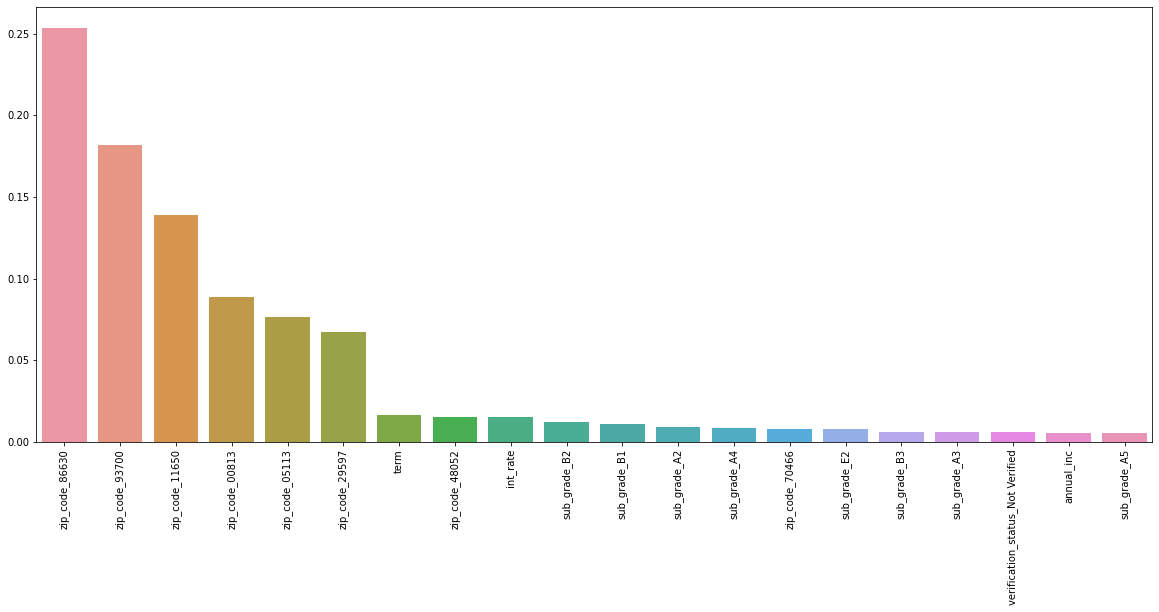

In [236]:
obj_cols = X_train.select_dtypes(exclude='number').columns
enc_attrs = xgbc_model.best_estimator_.named_steps['preprocessing'].transformers_[0][1].get_feature_names(obj_cols)
num_attrs = X_train.select_dtypes(include='number').columns

attrs = np.append(enc_attrs, num_attrs)
feat_imps = xgbc_model.best_estimator_[-1].feature_importances_

feat_imps_ser = pd.Series(index=attrs, data=feat_imps).sort_values(ascending=False)[:20] # top 20

plt.figure(figsize=(20, 8))
sns.barplot(x=feat_imps_ser.index, y=feat_imps_ser.values)
plt.xticks(rotation=90)
plt.show()

Unsurprisingly, based on our NN models above, we can see the feature importances top 5 are all of the zip_codes.

I will run another xgboostclassifier to see if it can do better than NN without the zip_code

In [244]:
# get rid of zip_code
X_train_no_zip = X_train.drop('zip_code', axis=1)
X_valid_no_zip = X_valid.drop('zip_code', axis=1)
X_test_no_zip = X_test.drop('zip_code', axis=1)

# new preprocessing
onehot = OneHotEncoder()

preprocessing_no_zip = ColumnTransformer([
    ('objs', onehot, X_train_no_zip.select_dtypes(exclude='number').columns)],
    remainder='passthrough')


pipeline = Pipeline([
    ('preprocessing', preprocessing_no_zip),
    ('xgbc', xgbc)
])

param_grid = {
    'xgbc__n_estimators': [50, 100],
    'xgbc__use_label_encoder': [False],
    'xgbc__max_depth': [4, 8],
    'xgbc__booster': ['gbtree'],
    'xgbc__subsample': [0.25, 0.75],
    'xgbc__colsample_bytree': [0.25, 0.75]    
}

xgbc_model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=2, scoring='accuracy')

In [245]:
xgbc_model.fit(X_train_no_zip, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[20:01:11] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.25, xgbc__max_depth=4, xgbc__n_estimators=50, xgbc__subsample=0.25, xgbc__use_label_encoder=False; total time=   3.2s
[20:01:15] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.25, xgbc__max_depth=4, xgbc__n_estimators=50, xgbc__subsample=0.25, xgbc__use_label_encoder=False; total time=   3.2s
[20:01:18] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default eval

[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.25, xgbc__max_depth=4, xgbc__n_estimators=100, xgbc__subsample=0.75, xgbc__use_label_encoder=False; total time=   7.1s
[20:03:05] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.25, xgbc__max_depth=8, xgbc__n_estimators=50, xgbc__subsample=0.25, xgbc__use_label_encoder=False; total time=   5.9s
[20:03:11] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.25, xgbc__max_depth=8, xgbc__n_estimators=50, xgbc__subsample=0.25, xgbc__use_label_encoder

[20:06:04] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.25, xgbc__max_depth=8, xgbc__n_estimators=100, xgbc__subsample=0.75, xgbc__use_label_encoder=False; total time=  14.2s
[20:06:19] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.75, xgbc__max_depth=4, xgbc__n_estimators=50, xgbc__subsample=0.25, xgbc__use_label_encoder=False; total time=   7.8s
[20:06:27] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was 

[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.75, xgbc__max_depth=4, xgbc__n_estimators=100, xgbc__subsample=0.75, xgbc__use_label_encoder=False; total time=  21.1s
[20:09:50] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.75, xgbc__max_depth=4, xgbc__n_estimators=100, xgbc__subsample=0.75, xgbc__use_label_encoder=False; total time=  24.4s
[20:10:14] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.75, xgbc__max_depth=8, xgbc__n_estimators=50, xgbc__subsample=0.25, xgbc__use_label_encode

[20:19:25] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.75, xgbc__max_depth=8, xgbc__n_estimators=100, xgbc__subsample=0.75, xgbc__use_label_encoder=False; total time=  46.1s
[20:20:11] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.75, xgbc__max_depth=8, xgbc__n_estimators=100, xgbc__subsample=0.75, xgbc__use_label_encoder=False; total time=  46.5s
[20:20:58] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('objs',
                                                                         OneHotEncoder(),
                                                                         Index(['sub_grade', 'emp_length', 'home_ownership', 'verification_status',
       'purpose', 'initial_list_status', 'application_type'],
      dtype='object'))])),
                                       ('xgbc',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylev...
                                                      reg_alpha=None,
                                                      reg_lambda=None,
                                

In [246]:
np.mean(np.sort(xgbc_model.cv_results_['mean_test_score'])[-5:])

0.8066355081810881

Without the zip_code feature, the accuracy does no better. I will change the scoring metric to see if it becomes better.

In [247]:
# get rid of zip_code
X_train_no_zip = X_train.drop('zip_code', axis=1)
X_valid_no_zip = X_valid.drop('zip_code', axis=1)
X_test_no_zip = X_test.drop('zip_code', axis=1)

# new preprocessing
onehot = OneHotEncoder()

preprocessing_no_zip = ColumnTransformer([
    ('objs', onehot, X_train_no_zip.select_dtypes(exclude='number').columns)],
    remainder='passthrough')


pipeline = Pipeline([
    ('preprocessing', preprocessing_no_zip),
    ('xgbc', xgbc)
])

param_grid = {
    'xgbc__n_estimators': [50],
    'xgbc__use_label_encoder': [False],
    'xgbc__max_depth': [4, 8],
    'xgbc__booster': ['gbtree'],
    'xgbc__subsample': [0.5],
    'xgbc__colsample_bytree': [0.25, 0.75]    
}

xgbc_model_prec = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=2, scoring='precision')

In [248]:
xgbc_model_prec.fit(X_train_no_zip, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[20:35:05] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.25, xgbc__max_depth=4, xgbc__n_estimators=50, xgbc__subsample=0.5, xgbc__use_label_encoder=False; total time=   7.1s
[20:35:12] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.25, xgbc__max_depth=4, xgbc__n_estimators=50, xgbc__subsample=0.5, xgbc__use_label_encoder=False; total time=   6.6s
[20:35:18] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluat

[CV] END xgbc__booster=gbtree, xgbc__colsample_bytree=0.75, xgbc__max_depth=8, xgbc__n_estimators=50, xgbc__subsample=0.5, xgbc__use_label_encoder=False; total time=  24.8s
[20:40:24] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('objs',
                                                                         OneHotEncoder(),
                                                                         Index(['sub_grade', 'emp_length', 'home_ownership', 'verification_status',
       'purpose', 'initial_list_status', 'application_type'],
      dtype='object'))])),
                                       ('xgbc',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylev...
                                                      random_state=None,
                                                      reg_alpha=None,
                              

In [249]:
xgbc_model_prec_preds = xgbc_model_prec.predict(X_test_no_zip)

In [251]:
print(classification_report(y_test, xgbc_model_prec_preds))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     31779
           1       0.54      0.07      0.12      7807

    accuracy                           0.80     39586
   macro avg       0.68      0.53      0.51     39586
weighted avg       0.76      0.80      0.74     39586



In [253]:
print(confusion_matrix(y_test, xgbc_model_prec_preds))

[[31325   454]
 [ 7277   530]]


In [254]:
xgbc_model_preds = xgbc_model.predict(X_test_no_zip)

In [255]:
print(classification_report(y_test, xgbc_model_preds))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     31779
           1       0.55      0.07      0.12      7807

    accuracy                           0.81     39586
   macro avg       0.68      0.53      0.51     39586
weighted avg       0.76      0.81      0.74     39586



In [256]:
print(confusion_matrix(y_test, xgbc_model_preds))

[[31325   454]
 [ 7259   548]]


## XGB vs NN models

In [257]:
# base model
xgbc = xgb.XGBClassifier(n_estimators=50, booster='gbtree', colsample_bytree=0.25,
                         max_depth=4, subsample=0.75, use_label_encoder=False)

# preprocessing (don't need to scale for tree methods)
onehot = OneHotEncoder(handle_unknown='ignore')

preprocessing = ColumnTransformer([
    ('objs', onehot, X_train.select_dtypes(exclude='number').columns)],
    remainder='passthrough')
    
xgbc_final = Pipeline([
    ('preprocessing', preprocessing),
    ('xgbc', xgbc)
])

xgbc_final.fit(X_train, y_train)

[21:04:36] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('objs',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['sub_grade', 'emp_length', 'home_ownership', 'verification_status',
       'purpose', 'initial_list_status', 'application_type', 'zip_code'],
      dtype='object'))])),
                ('xgbc',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsam...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=4, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=8, num_parallel_tree=

In [262]:
xgbc_preds = xgbc_final.predict(X_test)
nn_preds = np.where(model.predict(X_test_trans)<=0.5, 0, 1)

In [264]:
print(classification_report(y_test, xgbc_preds))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     31779
           1       0.95      0.46      0.62      7807

    accuracy                           0.89     39586
   macro avg       0.92      0.73      0.78     39586
weighted avg       0.90      0.89      0.87     39586



In [265]:
print(classification_report(y_test, nn_preds))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     31779
           1       0.92      0.47      0.63      7807

    accuracy                           0.89     39586
   macro avg       0.90      0.73      0.78     39586
weighted avg       0.89      0.89      0.87     39586



In [272]:
print(confusion_matrix(y_test, xgbc_preds))

[[31593   186]
 [ 4225  3582]]


In [267]:
print(confusion_matrix(y_test, nn_preds))

[[31454   325]
 [ 4109  3698]]


The models perform roughly the same. Due to interpretability (feature importances) of the XGBclassifier, I will keep this one.

In [274]:
dump(xgbc_final, 'XGBClassiferLendingTreeModel.joblib')

['XGBClassiferLendingTreeModel.joblib']

In [276]:
dump(preprocessing_nn, 'PreprocessForNN.joblib')

['PreprocessForNN.joblib']

In [278]:
model.save('KerasLendingTreeModel.h5')